# Test traditionnal approaches

A Hit Tagging model aims to predict the tag (0 for vertex activity, 1 for single particle, 2 for noise) of hits of an event in SFG. In this notebook we test two traditionnal approaches: a decision tree, and a simple volume cut

### Define paths

In [1]:
train_set_path="/scratch4/maubin/data/hittag_train"
test_set_path="/scratch4/maubin/data/hittag_test"

In [2]:
import importlib
from sfgnets.hit_tag_net import decision_tree
import graphviz
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np
import tqdm
importlib.reload(decision_tree);

Using cache found in /scratch/.maubin/cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


In [3]:
## Create train dataset
dataset=decision_tree.HitTagTreeDataset(root=train_set_path)
dataset.recon_ver=True
dataset.aux=True

In [4]:
## Extract flattened data
X,Y=dataset.XY
print(X.shape)
print(Y.shape)

L2Norm not defined, defaulting to True
(67184669, 2)
(67184669, 1)


In [5]:
## Fit a decision tree
ht_tree=decision_tree.DecisionTreeClassifier.fit(X,Y)

In [6]:
## Create test dataset
test_dataset=decision_tree.HitTagTreeDataset(root=test_set_path)
test_dataset.recon_ver=True
test_dataset.aux=True

In [7]:
## Extract flattened data
X_test,Y_test=test_dataset.XY

L2Norm not defined, defaulting to True


In [8]:
## Predict values on the test set
predictions=ht_tree.predict(X_test)

In [9]:
## Show performances
target_names = ["Vertex activity", "Track", "Noise"]
print(classification_report(Y_test,predictions, digits=3, target_names=target_names))

                 precision    recall  f1-score   support

Vertex activity      0.527     0.422     0.469    326390
          Track      0.893     0.827     0.859   6830081
          Noise      0.909     0.949     0.929  12631700

       accuracy                          0.899  19788171
      macro avg      0.776     0.733     0.752  19788171
   weighted avg      0.897     0.899     0.897  19788171



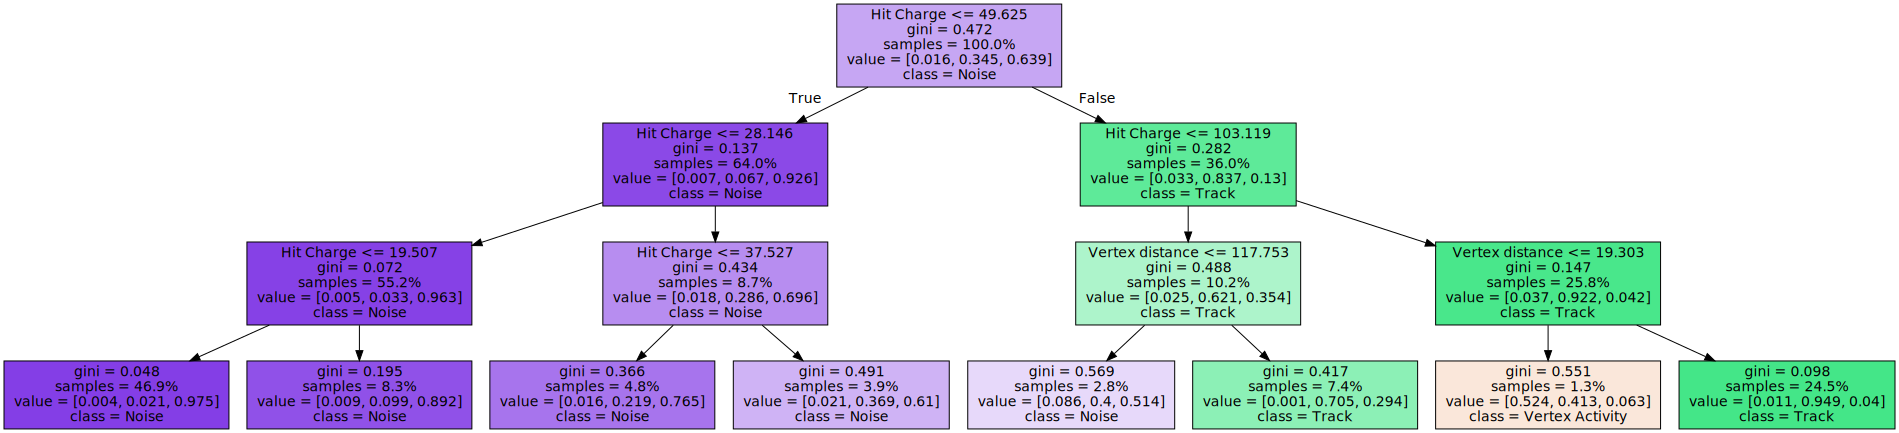

In [10]:
## Display decision tree
dot_data=decision_tree.tree.export_graphviz(ht_tree,
                                           feature_names=["Hit Charge", "Vertex distance"],
                                           class_names=["Vertex Activity", "Track", "Noise"],
                                           filled=True,
                                           proportion=True,
                                           fontname="Computer Modern")
graph = graphviz.Source(dot_data)
graph

In [11]:
## Test different volume cuts
dist_cuts=list(np.linspace(0.05,2.,32))+list(np.linspace(2.,10.,33))
P,R,F1=[],[],[]
for dist_cut in tqdm.tqdm(dist_cuts,desc="Computing performance of cuts:"):
    prec,reca, f1, _ = precision_recall_fscore_support(Y_test,(X_test[:,1]/10.27>dist_cut),average=None)
    P.append(prec)
    R.append(reca)
    F1.append(f1)

Computing performance of cuts::   0%|          | 0/65 [00:00<?, ?it/s]/home/maubin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Computing performance of cuts::   2%|▏         | 1/65 [00:05<05:37,  5.27s/it]/home/maubin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Computing performance of cuts::   3%|▎         | 2/65 [00:11<05:55,  5.65s/it]/home/maubin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precisio

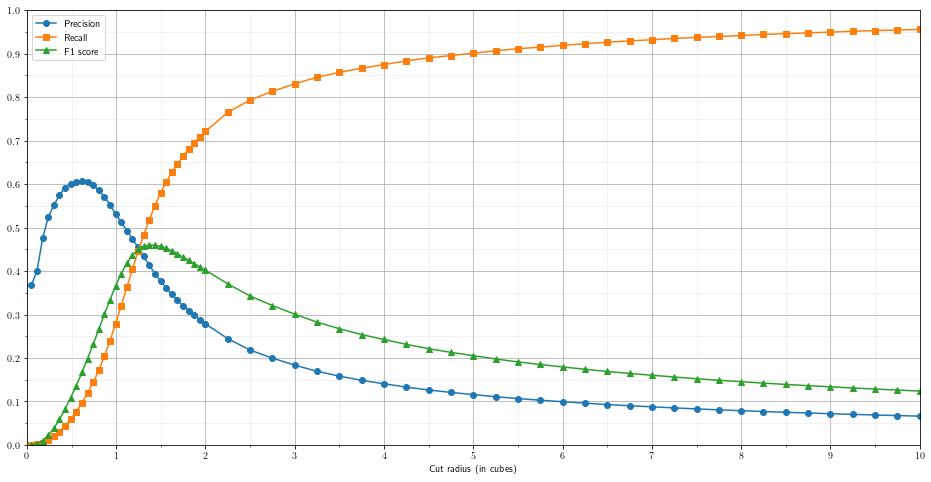

In [12]:
## Show the performances of the volume cuts for VA hits
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(16,8), facecolor="white")
ax = fig.add_subplot(111)
ax.plot(dist_cuts,[p[0] for p in P],label='Precision', marker='o')
ax.plot(dist_cuts,[r[0] for r in R],label='Recall', marker='s')
ax.plot(dist_cuts,[r[0] for r in F1],label='F1 score', marker='^')
ax.set_xlabel("Cut radius (in cubes)")
ax.legend()
# ax.set_title("Precision and Recall of reference classifier depending on the cut radius in cubes")
ax.set_xticks(np.linspace(0.,10.,11))
ax.set_xticks(np.linspace(0.,10.,21), minor=True)
ax.set_yticks(np.linspace(0.,1.,11))
ax.set_yticks(np.linspace(0.,1.,21), minor=True)
ax.set_xlim(0.,10.)
ax.set_ylim(0.,1.)
ax.grid()
ax.grid(which = 'minor', alpha = 0.2)
fig.show()

In [13]:
## Get best F1 score
F1[np.argmax(np.array(F1)[:,0])][0]

0.45973990320778796